# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [7]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

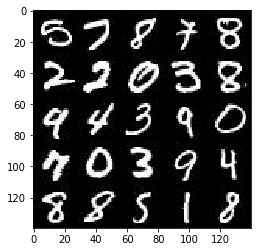

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

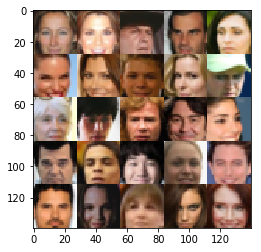

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)
 
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)

        flat   = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)

    d_out_real, d_logits_real =  discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake =  discriminator(g_model, reuse=True)

    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_real, labels = tf.ones_like(d_out_real)* (1 - 0.1)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.zeros_like(d_out_real)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, 0.5)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                print('step # {}'.format(steps))
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps %100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

step # 1
step # 2
step # 3
step # 4
step # 5
step # 6
step # 7
step # 8
step # 9
step # 10
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 1.6465
step # 11
step # 12
step # 13
step # 14
step # 15
step # 16
step # 17
step # 18
step # 19
step # 20
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 1.9929
step # 21
step # 22
step # 23
step # 24
step # 25
step # 26
step # 27
step # 28
step # 29
step # 30
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 2.2004
step # 31
step # 32
step # 33
step # 34
step # 35
step # 36
step # 37
step # 38
step # 39
step # 40
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.6681
step # 41
step # 42
step # 43
step # 44
step # 45
step # 46
step # 47
step # 48
step # 49
step # 50
Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 1.3368
step # 51
step # 52
step # 53
step # 54
step # 55
step # 56
step # 57
step # 58
step # 59
step # 60
Epoch 1/2... Discriminator Loss: 0.5538... Generator Loss: 2.1193
step # 61
ste

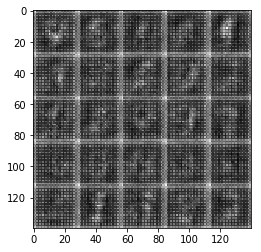

step # 101
step # 102
step # 103
step # 104
step # 105
step # 106
step # 107
step # 108
step # 109
step # 110
Epoch 1/2... Discriminator Loss: 0.6415... Generator Loss: 2.2419
step # 111
step # 112
step # 113
step # 114
step # 115
step # 116
step # 117
step # 118
step # 119
step # 120
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 4.0418
step # 121
step # 122
step # 123
step # 124
step # 125
step # 126
step # 127
step # 128
step # 129
step # 130
Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 2.0767
step # 131
step # 132
step # 133
step # 134
step # 135
step # 136
step # 137
step # 138
step # 139
step # 140
Epoch 1/2... Discriminator Loss: 0.6297... Generator Loss: 2.0976
step # 141
step # 142
step # 143
step # 144
step # 145
step # 146
step # 147
step # 148
step # 149
step # 150
Epoch 1/2... Discriminator Loss: 0.6374... Generator Loss: 2.3282
step # 151
step # 152
step # 153
step # 154
step # 155
step # 156
step # 157
step # 158
step # 159
step # 160
Epoch 1/2.

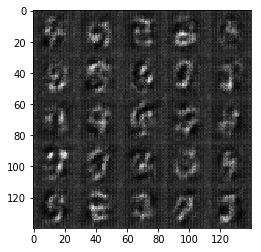

step # 201
step # 202
step # 203
step # 204
step # 205
step # 206
step # 207
step # 208
step # 209
step # 210
Epoch 1/2... Discriminator Loss: 0.6344... Generator Loss: 2.1208
step # 211
step # 212
step # 213
step # 214
step # 215
step # 216
step # 217
step # 218
step # 219
step # 220
Epoch 1/2... Discriminator Loss: 0.7085... Generator Loss: 1.2925
step # 221
step # 222
step # 223
step # 224
step # 225
step # 226
step # 227
step # 228
step # 229
step # 230
Epoch 1/2... Discriminator Loss: 0.6843... Generator Loss: 1.3836
step # 231
step # 232
step # 233
step # 234
step # 235
step # 236
step # 237
step # 238
step # 239
step # 240
Epoch 1/2... Discriminator Loss: 0.5633... Generator Loss: 2.6181
step # 241
step # 242
step # 243
step # 244
step # 245
step # 246
step # 247
step # 248
step # 249
step # 250
Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 2.8621
step # 251
step # 252
step # 253
step # 254
step # 255
step # 256
step # 257
step # 258
step # 259
step # 260
Epoch 1/2.

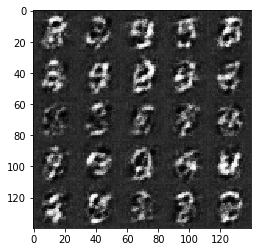

step # 301
step # 302
step # 303
step # 304
step # 305
step # 306
step # 307
step # 308
step # 309
step # 310
Epoch 1/2... Discriminator Loss: 0.5452... Generator Loss: 1.8019
step # 311
step # 312
step # 313
step # 314
step # 315
step # 316
step # 317
step # 318
step # 319
step # 320
Epoch 1/2... Discriminator Loss: 0.5227... Generator Loss: 2.2865
step # 321
step # 322
step # 323
step # 324
step # 325
step # 326
step # 327
step # 328
step # 329
step # 330
Epoch 1/2... Discriminator Loss: 0.5706... Generator Loss: 1.8014
step # 331
step # 332
step # 333
step # 334
step # 335
step # 336
step # 337
step # 338
step # 339
step # 340
Epoch 1/2... Discriminator Loss: 1.5316... Generator Loss: 0.4737
step # 341
step # 342
step # 343
step # 344
step # 345
step # 346
step # 347
step # 348
step # 349
step # 350
Epoch 1/2... Discriminator Loss: 0.4413... Generator Loss: 2.7213
step # 351
step # 352
step # 353
step # 354
step # 355
step # 356
step # 357
step # 358
step # 359
step # 360
Epoch 1/2.

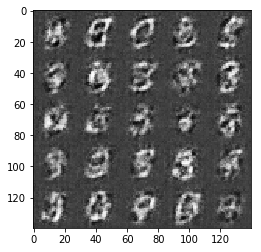

step # 401
step # 402
step # 403
step # 404
step # 405
step # 406
step # 407
step # 408
step # 409
step # 410
Epoch 1/2... Discriminator Loss: 0.4408... Generator Loss: 2.6821
step # 411
step # 412
step # 413
step # 414
step # 415
step # 416
step # 417
step # 418
step # 419
step # 420
Epoch 1/2... Discriminator Loss: 0.4886... Generator Loss: 2.2789
step # 421
step # 422
step # 423
step # 424
step # 425
step # 426
step # 427
step # 428
step # 429
step # 430
Epoch 1/2... Discriminator Loss: 0.4220... Generator Loss: 2.9173
step # 431
step # 432
step # 433
step # 434
step # 435
step # 436
step # 437
step # 438
step # 439
step # 440
Epoch 1/2... Discriminator Loss: 0.4532... Generator Loss: 2.5931
step # 441
step # 442
step # 443
step # 444
step # 445
step # 446
step # 447
step # 448
step # 449
step # 450
Epoch 1/2... Discriminator Loss: 0.4515... Generator Loss: 2.8514
step # 451
step # 452
step # 453
step # 454
step # 455
step # 456
step # 457
step # 458
step # 459
step # 460
Epoch 1/2.

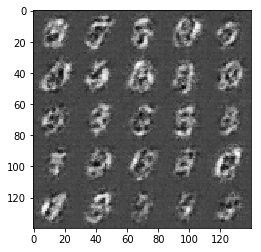

step # 501
step # 502
step # 503
step # 504
step # 505
step # 506
step # 507
step # 508
step # 509
step # 510
Epoch 1/2... Discriminator Loss: 0.4198... Generator Loss: 2.8854
step # 511
step # 512
step # 513
step # 514
step # 515
step # 516
step # 517
step # 518
step # 519
step # 520
Epoch 1/2... Discriminator Loss: 0.4284... Generator Loss: 3.1373
step # 521
step # 522
step # 523
step # 524
step # 525
step # 526
step # 527
step # 528
step # 529
step # 530
Epoch 1/2... Discriminator Loss: 0.4315... Generator Loss: 3.0762
step # 531
step # 532
step # 533
step # 534
step # 535
step # 536
step # 537
step # 538
step # 539
step # 540
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 3.0241
step # 541
step # 542
step # 543
step # 544
step # 545
step # 546
step # 547
step # 548
step # 549
step # 550
Epoch 1/2... Discriminator Loss: 0.4365... Generator Loss: 2.6532
step # 551
step # 552
step # 553
step # 554
step # 555
step # 556
step # 557
step # 558
step # 559
step # 560
Epoch 1/2.

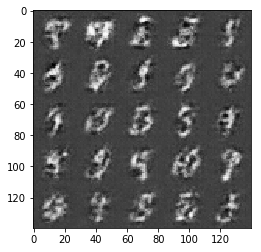

step # 601
step # 602
step # 603
step # 604
step # 605
step # 606
step # 607
step # 608
step # 609
step # 610
Epoch 1/2... Discriminator Loss: 0.4911... Generator Loss: 2.1705
step # 611
step # 612
step # 613
step # 614
step # 615
step # 616
step # 617
step # 618
step # 619
step # 620
Epoch 1/2... Discriminator Loss: 0.4116... Generator Loss: 2.9558
step # 621
step # 622
step # 623
step # 624
step # 625
step # 626
step # 627
step # 628
step # 629
step # 630
Epoch 1/2... Discriminator Loss: 0.4320... Generator Loss: 3.6818
step # 631
step # 632
step # 633
step # 634
step # 635
step # 636
step # 637
step # 638
step # 639
step # 640
Epoch 1/2... Discriminator Loss: 0.4400... Generator Loss: 4.1708
step # 641
step # 642
step # 643
step # 644
step # 645
step # 646
step # 647
step # 648
step # 649
step # 650
Epoch 1/2... Discriminator Loss: 0.4108... Generator Loss: 3.2204
step # 651
step # 652
step # 653
step # 654
step # 655
step # 656
step # 657
step # 658
step # 659
step # 660
Epoch 1/2.

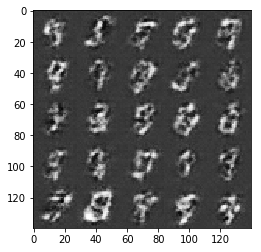

step # 701
step # 702
step # 703
step # 704
step # 705
step # 706
step # 707
step # 708
step # 709
step # 710
Epoch 1/2... Discriminator Loss: 0.4672... Generator Loss: 2.2729
step # 711
step # 712
step # 713
step # 714
step # 715
step # 716
step # 717
step # 718
step # 719
step # 720
Epoch 1/2... Discriminator Loss: 0.4033... Generator Loss: 3.0469
step # 721
step # 722
step # 723
step # 724
step # 725
step # 726
step # 727
step # 728
step # 729
step # 730
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 3.4353
step # 731
step # 732
step # 733
step # 734
step # 735
step # 736
step # 737
step # 738
step # 739
step # 740
Epoch 1/2... Discriminator Loss: 0.4198... Generator Loss: 2.7789
step # 741
step # 742
step # 743
step # 744
step # 745
step # 746
step # 747
step # 748
step # 749
step # 750
Epoch 1/2... Discriminator Loss: 0.3843... Generator Loss: 3.7445
step # 751
step # 752
step # 753
step # 754
step # 755
step # 756
step # 757
step # 758
step # 759
step # 760
Epoch 1/2.

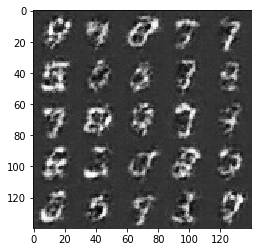

step # 801
step # 802
step # 803
step # 804
step # 805
step # 806
step # 807
step # 808
step # 809
step # 810
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 3.2326
step # 811
step # 812
step # 813
step # 814
step # 815
step # 816
step # 817
step # 818
step # 819
step # 820
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 2.8547
step # 821
step # 822
step # 823
step # 824
step # 825
step # 826
step # 827
step # 828
step # 829
step # 830
Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 4.1971
step # 831
step # 832
step # 833
step # 834
step # 835
step # 836
step # 837
step # 838
step # 839
step # 840
Epoch 1/2... Discriminator Loss: 0.4139... Generator Loss: 2.8966
step # 841
step # 842
step # 843
step # 844
step # 845
step # 846
step # 847
step # 848
step # 849
step # 850
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 1.3128
step # 851
step # 852
step # 853
step # 854
step # 855
step # 856
step # 857
step # 858
step # 859
step # 860
Epoch 1/2.

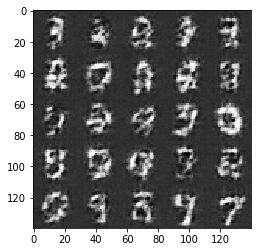

step # 901
step # 902
step # 903
step # 904
step # 905
step # 906
step # 907
step # 908
step # 909
step # 910
Epoch 1/2... Discriminator Loss: 0.3745... Generator Loss: 3.8241
step # 911
step # 912
step # 913
step # 914
step # 915
step # 916
step # 917
step # 918
step # 919
step # 920
Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 3.7229
step # 921
step # 922
step # 923
step # 924
step # 925
step # 926
step # 927
step # 928
step # 929
step # 930
Epoch 1/2... Discriminator Loss: 0.3834... Generator Loss: 4.0390
step # 931
step # 932
step # 933
step # 934
step # 935
step # 936
step # 937
step # 938
step # 939
step # 940
Epoch 2/2... Discriminator Loss: 0.4592... Generator Loss: 2.4771
step # 941
step # 942
step # 943
step # 944
step # 945
step # 946
step # 947
step # 948
step # 949
step # 950
Epoch 2/2... Discriminator Loss: 0.4039... Generator Loss: 3.0315
step # 951
step # 952
step # 953
step # 954
step # 955
step # 956
step # 957
step # 958
step # 959
step # 960
Epoch 2/2.

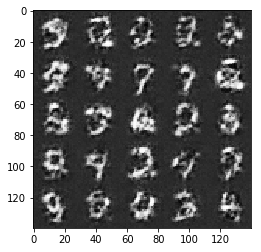

step # 1001
step # 1002
step # 1003
step # 1004
step # 1005
step # 1006
step # 1007
step # 1008
step # 1009
step # 1010
Epoch 2/2... Discriminator Loss: 0.3758... Generator Loss: 3.5496
step # 1011
step # 1012
step # 1013
step # 1014
step # 1015
step # 1016
step # 1017
step # 1018
step # 1019
step # 1020
Epoch 2/2... Discriminator Loss: 0.3631... Generator Loss: 3.9214
step # 1021
step # 1022
step # 1023
step # 1024
step # 1025
step # 1026
step # 1027
step # 1028
step # 1029
step # 1030
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.1518
step # 1031
step # 1032
step # 1033
step # 1034
step # 1035
step # 1036
step # 1037
step # 1038
step # 1039
step # 1040
Epoch 2/2... Discriminator Loss: 0.3632... Generator Loss: 4.2193
step # 1041
step # 1042
step # 1043
step # 1044
step # 1045
step # 1046
step # 1047
step # 1048
step # 1049
step # 1050
Epoch 2/2... Discriminator Loss: 0.3731... Generator Loss: 3.8268
step # 1051
step # 1052
step # 1053
step # 1054
step # 1055
step # 105

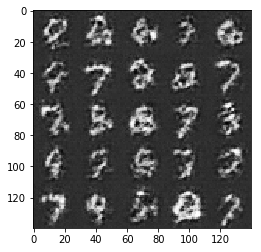

step # 1101
step # 1102
step # 1103
step # 1104
step # 1105
step # 1106
step # 1107
step # 1108
step # 1109
step # 1110
Epoch 2/2... Discriminator Loss: 0.4466... Generator Loss: 2.6181
step # 1111
step # 1112
step # 1113
step # 1114
step # 1115
step # 1116
step # 1117
step # 1118
step # 1119
step # 1120
Epoch 2/2... Discriminator Loss: 0.3949... Generator Loss: 3.5333
step # 1121
step # 1122
step # 1123
step # 1124
step # 1125
step # 1126
step # 1127
step # 1128
step # 1129
step # 1130
Epoch 2/2... Discriminator Loss: 0.3666... Generator Loss: 4.1389
step # 1131
step # 1132
step # 1133
step # 1134
step # 1135
step # 1136
step # 1137
step # 1138
step # 1139
step # 1140
Epoch 2/2... Discriminator Loss: 0.3966... Generator Loss: 2.9789
step # 1141
step # 1142
step # 1143
step # 1144
step # 1145
step # 1146
step # 1147
step # 1148
step # 1149
step # 1150
Epoch 2/2... Discriminator Loss: 0.3865... Generator Loss: 3.2127
step # 1151
step # 1152
step # 1153
step # 1154
step # 1155
step # 115

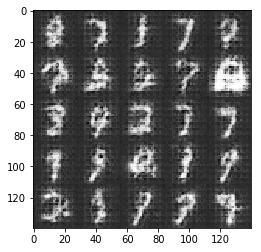

step # 1201
step # 1202
step # 1203
step # 1204
step # 1205
step # 1206
step # 1207
step # 1208
step # 1209
step # 1210
Epoch 2/2... Discriminator Loss: 0.4881... Generator Loss: 2.7070
step # 1211
step # 1212
step # 1213
step # 1214
step # 1215
step # 1216
step # 1217
step # 1218
step # 1219
step # 1220
Epoch 2/2... Discriminator Loss: 0.4132... Generator Loss: 2.9105
step # 1221
step # 1222
step # 1223
step # 1224
step # 1225
step # 1226
step # 1227
step # 1228
step # 1229
step # 1230
Epoch 2/2... Discriminator Loss: 0.4460... Generator Loss: 3.4283
step # 1231
step # 1232
step # 1233
step # 1234
step # 1235
step # 1236
step # 1237
step # 1238
step # 1239
step # 1240
Epoch 2/2... Discriminator Loss: 0.4065... Generator Loss: 2.9037
step # 1241
step # 1242
step # 1243
step # 1244
step # 1245
step # 1246
step # 1247
step # 1248
step # 1249
step # 1250
Epoch 2/2... Discriminator Loss: 0.4439... Generator Loss: 2.4932
step # 1251
step # 1252
step # 1253
step # 1254
step # 1255
step # 125

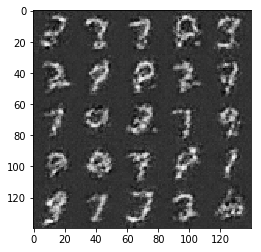

step # 1301
step # 1302
step # 1303
step # 1304
step # 1305
step # 1306
step # 1307
step # 1308
step # 1309
step # 1310
Epoch 2/2... Discriminator Loss: 0.6023... Generator Loss: 1.8144
step # 1311
step # 1312
step # 1313
step # 1314
step # 1315
step # 1316
step # 1317
step # 1318
step # 1319
step # 1320
Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 3.3729
step # 1321
step # 1322
step # 1323
step # 1324
step # 1325
step # 1326
step # 1327
step # 1328
step # 1329
step # 1330
Epoch 2/2... Discriminator Loss: 0.5256... Generator Loss: 2.0545
step # 1331
step # 1332
step # 1333
step # 1334
step # 1335
step # 1336
step # 1337
step # 1338
step # 1339
step # 1340
Epoch 2/2... Discriminator Loss: 0.3961... Generator Loss: 3.1008
step # 1341
step # 1342
step # 1343
step # 1344
step # 1345
step # 1346
step # 1347
step # 1348
step # 1349
step # 1350
Epoch 2/2... Discriminator Loss: 0.4218... Generator Loss: 3.5995
step # 1351
step # 1352
step # 1353
step # 1354
step # 1355
step # 135

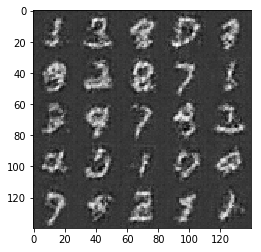

step # 1401
step # 1402
step # 1403
step # 1404
step # 1405
step # 1406
step # 1407
step # 1408
step # 1409
step # 1410
Epoch 2/2... Discriminator Loss: 0.3898... Generator Loss: 3.1025
step # 1411
step # 1412
step # 1413
step # 1414
step # 1415
step # 1416
step # 1417
step # 1418
step # 1419
step # 1420
Epoch 2/2... Discriminator Loss: 0.3888... Generator Loss: 3.2021
step # 1421
step # 1422
step # 1423
step # 1424
step # 1425
step # 1426
step # 1427
step # 1428
step # 1429
step # 1430
Epoch 2/2... Discriminator Loss: 0.4012... Generator Loss: 4.3282
step # 1431
step # 1432
step # 1433
step # 1434
step # 1435
step # 1436
step # 1437
step # 1438
step # 1439
step # 1440
Epoch 2/2... Discriminator Loss: 0.3959... Generator Loss: 3.0788
step # 1441
step # 1442
step # 1443
step # 1444
step # 1445
step # 1446
step # 1447
step # 1448
step # 1449
step # 1450
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 2.5513
step # 1451
step # 1452
step # 1453
step # 1454
step # 1455
step # 145

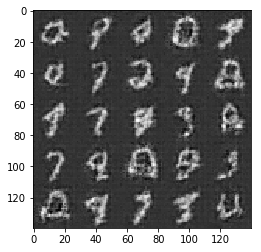

step # 1501
step # 1502
step # 1503
step # 1504
step # 1505
step # 1506
step # 1507
step # 1508
step # 1509
step # 1510
Epoch 2/2... Discriminator Loss: 0.4720... Generator Loss: 2.8792
step # 1511
step # 1512
step # 1513
step # 1514
step # 1515
step # 1516
step # 1517
step # 1518
step # 1519
step # 1520
Epoch 2/2... Discriminator Loss: 0.3781... Generator Loss: 3.4324
step # 1521
step # 1522
step # 1523
step # 1524
step # 1525
step # 1526
step # 1527
step # 1528
step # 1529
step # 1530
Epoch 2/2... Discriminator Loss: 0.3895... Generator Loss: 3.2187
step # 1531
step # 1532
step # 1533
step # 1534
step # 1535
step # 1536
step # 1537
step # 1538
step # 1539
step # 1540
Epoch 2/2... Discriminator Loss: 0.3917... Generator Loss: 3.0431
step # 1541
step # 1542
step # 1543
step # 1544
step # 1545
step # 1546
step # 1547
step # 1548
step # 1549
step # 1550
Epoch 2/2... Discriminator Loss: 0.4103... Generator Loss: 2.8146
step # 1551
step # 1552
step # 1553
step # 1554
step # 1555
step # 155

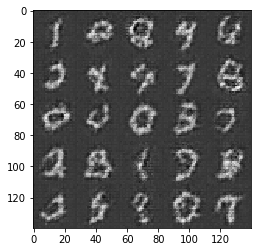

step # 1601
step # 1602
step # 1603
step # 1604
step # 1605
step # 1606
step # 1607
step # 1608
step # 1609
step # 1610
Epoch 2/2... Discriminator Loss: 0.4491... Generator Loss: 2.4899
step # 1611
step # 1612
step # 1613
step # 1614
step # 1615
step # 1616
step # 1617
step # 1618
step # 1619
step # 1620
Epoch 2/2... Discriminator Loss: 0.4717... Generator Loss: 2.2047
step # 1621
step # 1622
step # 1623
step # 1624
step # 1625
step # 1626
step # 1627
step # 1628
step # 1629
step # 1630
Epoch 2/2... Discriminator Loss: 0.4354... Generator Loss: 3.0320
step # 1631
step # 1632
step # 1633
step # 1634
step # 1635
step # 1636
step # 1637
step # 1638
step # 1639
step # 1640
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 3.1268
step # 1641
step # 1642
step # 1643
step # 1644
step # 1645
step # 1646
step # 1647
step # 1648
step # 1649
step # 1650
Epoch 2/2... Discriminator Loss: 0.4394... Generator Loss: 2.4993
step # 1651
step # 1652
step # 1653
step # 1654
step # 1655
step # 165

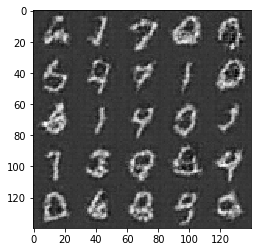

step # 1701
step # 1702
step # 1703
step # 1704
step # 1705
step # 1706
step # 1707
step # 1708
step # 1709
step # 1710
Epoch 2/2... Discriminator Loss: 0.4436... Generator Loss: 2.4679
step # 1711
step # 1712
step # 1713
step # 1714
step # 1715
step # 1716
step # 1717
step # 1718
step # 1719
step # 1720
Epoch 2/2... Discriminator Loss: 0.3996... Generator Loss: 3.7134
step # 1721
step # 1722
step # 1723
step # 1724
step # 1725
step # 1726
step # 1727
step # 1728
step # 1729
step # 1730
Epoch 2/2... Discriminator Loss: 0.4692... Generator Loss: 2.2319
step # 1731
step # 1732
step # 1733
step # 1734
step # 1735
step # 1736
step # 1737
step # 1738
step # 1739
step # 1740
Epoch 2/2... Discriminator Loss: 0.4203... Generator Loss: 3.0606
step # 1741
step # 1742
step # 1743
step # 1744
step # 1745
step # 1746
step # 1747
step # 1748
step # 1749
step # 1750
Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 2.9994
step # 1751
step # 1752
step # 1753
step # 1754
step # 1755
step # 175

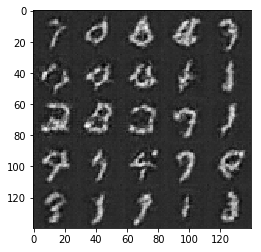

step # 1801
step # 1802
step # 1803
step # 1804
step # 1805
step # 1806
step # 1807
step # 1808
step # 1809
step # 1810
Epoch 2/2... Discriminator Loss: 1.3209... Generator Loss: 4.9173
step # 1811
step # 1812
step # 1813
step # 1814
step # 1815
step # 1816
step # 1817
step # 1818
step # 1819
step # 1820
Epoch 2/2... Discriminator Loss: 0.8149... Generator Loss: 1.3401
step # 1821
step # 1822
step # 1823
step # 1824
step # 1825
step # 1826
step # 1827
step # 1828
step # 1829
step # 1830
Epoch 2/2... Discriminator Loss: 0.5441... Generator Loss: 2.3262
step # 1831
step # 1832
step # 1833
step # 1834
step # 1835
step # 1836
step # 1837
step # 1838
step # 1839
step # 1840
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 1.9487
step # 1841
step # 1842
step # 1843
step # 1844
step # 1845
step # 1846
step # 1847
step # 1848
step # 1849
step # 1850
Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 2.6137
step # 1851
step # 1852
step # 1853
step # 1854
step # 1855
step # 185

In [31]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

step # 1
step # 2
step # 3
step # 4
step # 5
step # 6
step # 7
step # 8
step # 9
step # 10
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.6093
step # 11
step # 12
step # 13
step # 14
step # 15
step # 16
step # 17
step # 18
step # 19
step # 20
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.6415
step # 21
step # 22
step # 23
step # 24
step # 25
step # 26
step # 27
step # 28
step # 29
step # 30
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 2.0522
step # 31
step # 32
step # 33
step # 34
step # 35
step # 36
step # 37
step # 38
step # 39
step # 40
Epoch 1/1... Discriminator Loss: 0.4635... Generator Loss: 2.8828
step # 41
step # 42
step # 43
step # 44
step # 45
step # 46
step # 47
step # 48
step # 49
step # 50
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 2.5918
step # 51
step # 52
step # 53
step # 54
step # 55
step # 56
step # 57
step # 58
step # 59
step # 60
Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 3.2711
step # 61
ste

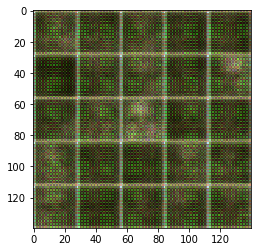

step # 101
step # 102
step # 103
step # 104
step # 105
step # 106
step # 107
step # 108
step # 109
step # 110
Epoch 1/1... Discriminator Loss: 1.7865... Generator Loss: 5.0752
step # 111
step # 112
step # 113
step # 114
step # 115
step # 116
step # 117
step # 118
step # 119
step # 120
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.2153
step # 121
step # 122
step # 123
step # 124
step # 125
step # 126
step # 127
step # 128
step # 129
step # 130
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 3.9905
step # 131
step # 132
step # 133
step # 134
step # 135
step # 136
step # 137
step # 138
step # 139
step # 140
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 2.1665
step # 141
step # 142
step # 143
step # 144
step # 145
step # 146
step # 147
step # 148
step # 149
step # 150
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.5646
step # 151
step # 152
step # 153
step # 154
step # 155
step # 156
step # 157
step # 158
step # 159
step # 160
Epoch 1/1.

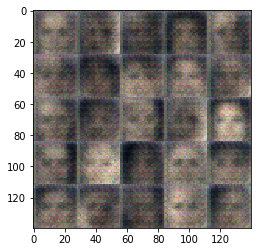

step # 201
step # 202
step # 203
step # 204
step # 205
step # 206
step # 207
step # 208
step # 209
step # 210
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.9469
step # 211
step # 212
step # 213
step # 214
step # 215
step # 216
step # 217
step # 218
step # 219
step # 220
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.7908
step # 221
step # 222
step # 223
step # 224
step # 225
step # 226
step # 227
step # 228
step # 229
step # 230
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.4756
step # 231
step # 232
step # 233
step # 234
step # 235
step # 236
step # 237
step # 238
step # 239
step # 240
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 1.5766
step # 241
step # 242
step # 243
step # 244
step # 245
step # 246
step # 247
step # 248
step # 249
step # 250
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.8263
step # 251
step # 252
step # 253
step # 254
step # 255
step # 256
step # 257
step # 258
step # 259
step # 260
Epoch 1/1.

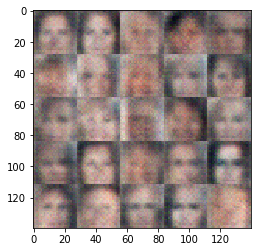

step # 301
step # 302
step # 303
step # 304
step # 305
step # 306
step # 307
step # 308
step # 309
step # 310
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 2.7398
step # 311
step # 312
step # 313
step # 314
step # 315
step # 316
step # 317
step # 318
step # 319
step # 320
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.8226
step # 321
step # 322
step # 323
step # 324
step # 325
step # 326
step # 327
step # 328
step # 329
step # 330
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8077
step # 331
step # 332
step # 333
step # 334
step # 335
step # 336
step # 337
step # 338
step # 339
step # 340
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 3.0357
step # 341
step # 342
step # 343
step # 344
step # 345
step # 346
step # 347
step # 348
step # 349
step # 350
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.1929
step # 351
step # 352
step # 353
step # 354
step # 355
step # 356
step # 357
step # 358
step # 359
step # 360
Epoch 1/1.

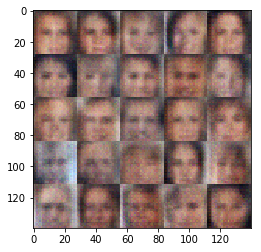

step # 401
step # 402
step # 403
step # 404
step # 405
step # 406
step # 407
step # 408
step # 409
step # 410
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.7689
step # 411
step # 412
step # 413
step # 414
step # 415
step # 416
step # 417
step # 418
step # 419
step # 420
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.1140
step # 421
step # 422
step # 423
step # 424
step # 425
step # 426
step # 427
step # 428
step # 429
step # 430
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.3452
step # 431
step # 432
step # 433
step # 434
step # 435
step # 436
step # 437
step # 438
step # 439
step # 440
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.1122
step # 441
step # 442
step # 443
step # 444
step # 445
step # 446
step # 447
step # 448
step # 449
step # 450
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 0.9634
step # 451
step # 452
step # 453
step # 454
step # 455
step # 456
step # 457
step # 458
step # 459
step # 460
Epoch 1/1.

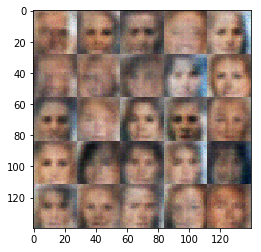

step # 501
step # 502
step # 503
step # 504
step # 505
step # 506
step # 507
step # 508
step # 509
step # 510
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.2573
step # 511
step # 512
step # 513
step # 514
step # 515
step # 516
step # 517
step # 518
step # 519
step # 520
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.5608
step # 521
step # 522
step # 523
step # 524
step # 525
step # 526
step # 527
step # 528
step # 529
step # 530
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 0.9025
step # 531
step # 532
step # 533
step # 534
step # 535
step # 536
step # 537
step # 538
step # 539
step # 540
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.3476
step # 541
step # 542
step # 543
step # 544
step # 545
step # 546
step # 547
step # 548
step # 549
step # 550
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 2.0623
step # 551
step # 552
step # 553
step # 554
step # 555
step # 556
step # 557
step # 558
step # 559
step # 560
Epoch 1/1.

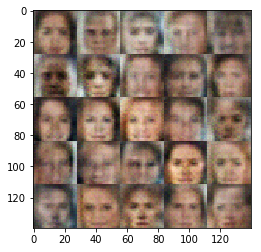

step # 601
step # 602
step # 603
step # 604
step # 605
step # 606
step # 607
step # 608
step # 609
step # 610
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.4053
step # 611
step # 612
step # 613
step # 614
step # 615
step # 616
step # 617
step # 618
step # 619
step # 620
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 2.5701
step # 621
step # 622
step # 623
step # 624
step # 625
step # 626
step # 627
step # 628
step # 629
step # 630
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 2.2959
step # 631
step # 632
step # 633
step # 634
step # 635
step # 636
step # 637
step # 638
step # 639
step # 640
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.3818
step # 641
step # 642
step # 643
step # 644
step # 645
step # 646
step # 647
step # 648
step # 649
step # 650
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 2.4930
step # 651
step # 652
step # 653
step # 654
step # 655
step # 656
step # 657
step # 658
step # 659
step # 660
Epoch 1/1.

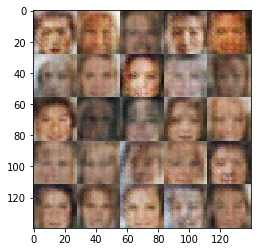

step # 701
step # 702
step # 703
step # 704
step # 705
step # 706
step # 707
step # 708
step # 709
step # 710
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.0567
step # 711
step # 712
step # 713
step # 714
step # 715
step # 716
step # 717
step # 718
step # 719
step # 720
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.7505
step # 721
step # 722
step # 723
step # 724
step # 725
step # 726
step # 727
step # 728
step # 729
step # 730
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.4847
step # 731
step # 732
step # 733
step # 734
step # 735
step # 736
step # 737
step # 738
step # 739
step # 740
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.7699
step # 741
step # 742
step # 743
step # 744
step # 745
step # 746
step # 747
step # 748
step # 749
step # 750
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.7574
step # 751
step # 752
step # 753
step # 754
step # 755
step # 756
step # 757
step # 758
step # 759
step # 760
Epoch 1/1.

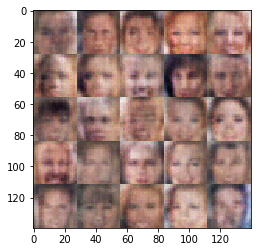

step # 801
step # 802
step # 803
step # 804
step # 805
step # 806
step # 807
step # 808
step # 809
step # 810
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.2828
step # 811
step # 812
step # 813
step # 814
step # 815
step # 816
step # 817
step # 818
step # 819
step # 820
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.2503
step # 821
step # 822
step # 823
step # 824
step # 825
step # 826
step # 827
step # 828
step # 829
step # 830
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 3.4009
step # 831
step # 832
step # 833
step # 834
step # 835
step # 836
step # 837
step # 838
step # 839
step # 840
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.6106
step # 841
step # 842
step # 843
step # 844
step # 845
step # 846
step # 847
step # 848
step # 849
step # 850
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 0.9733
step # 851
step # 852
step # 853
step # 854
step # 855
step # 856
step # 857
step # 858
step # 859
step # 860
Epoch 1/1.

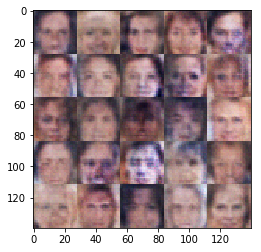

step # 901
step # 902
step # 903
step # 904
step # 905
step # 906
step # 907
step # 908
step # 909
step # 910
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 3.2028
step # 911
step # 912
step # 913
step # 914
step # 915
step # 916
step # 917
step # 918
step # 919
step # 920
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 3.3866
step # 921
step # 922
step # 923
step # 924
step # 925
step # 926
step # 927
step # 928
step # 929
step # 930
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 3.1084
step # 931
step # 932
step # 933
step # 934
step # 935
step # 936
step # 937
step # 938
step # 939
step # 940
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 3.4725
step # 941
step # 942
step # 943
step # 944
step # 945
step # 946
step # 947
step # 948
step # 949
step # 950
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 2.7066
step # 951
step # 952
step # 953
step # 954
step # 955
step # 956
step # 957
step # 958
step # 959
step # 960
Epoch 1/1.

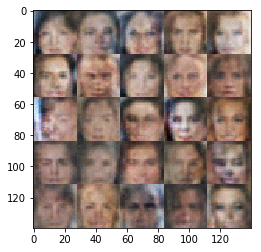

step # 1001
step # 1002
step # 1003
step # 1004
step # 1005
step # 1006
step # 1007
step # 1008
step # 1009
step # 1010
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 1.9750
step # 1011
step # 1012
step # 1013
step # 1014
step # 1015
step # 1016
step # 1017
step # 1018
step # 1019
step # 1020
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.0258
step # 1021
step # 1022
step # 1023
step # 1024
step # 1025
step # 1026
step # 1027
step # 1028
step # 1029
step # 1030
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.5783
step # 1031
step # 1032
step # 1033
step # 1034
step # 1035
step # 1036
step # 1037
step # 1038
step # 1039
step # 1040
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.0621
step # 1041
step # 1042
step # 1043
step # 1044
step # 1045
step # 1046
step # 1047
step # 1048
step # 1049
step # 1050
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.7521
step # 1051
step # 1052
step # 1053
step # 1054
step # 1055
step # 105

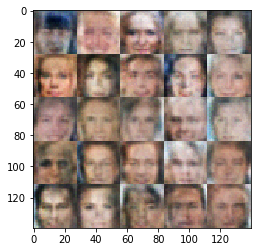

step # 1101
step # 1102
step # 1103
step # 1104
step # 1105
step # 1106
step # 1107
step # 1108
step # 1109
step # 1110
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 2.8699
step # 1111
step # 1112
step # 1113
step # 1114
step # 1115
step # 1116
step # 1117
step # 1118
step # 1119
step # 1120
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 10.0282
step # 1121
step # 1122
step # 1123
step # 1124
step # 1125
step # 1126
step # 1127
step # 1128
step # 1129
step # 1130
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 2.6354
step # 1131
step # 1132
step # 1133
step # 1134
step # 1135
step # 1136
step # 1137
step # 1138
step # 1139
step # 1140
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 4.0735
step # 1141
step # 1142
step # 1143
step # 1144
step # 1145
step # 1146
step # 1147
step # 1148
step # 1149
step # 1150
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 0.9849
step # 1151
step # 1152
step # 1153
step # 1154
step # 1155
step # 11

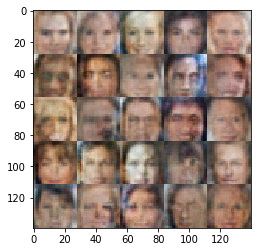

step # 1201
step # 1202
step # 1203
step # 1204
step # 1205
step # 1206
step # 1207
step # 1208
step # 1209
step # 1210
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 2.2655
step # 1211
step # 1212
step # 1213
step # 1214
step # 1215
step # 1216
step # 1217
step # 1218
step # 1219
step # 1220
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 5.2302
step # 1221
step # 1222
step # 1223
step # 1224
step # 1225
step # 1226
step # 1227
step # 1228
step # 1229
step # 1230
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 6.9381
step # 1231
step # 1232
step # 1233
step # 1234
step # 1235
step # 1236
step # 1237
step # 1238
step # 1239
step # 1240
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 4.6331
step # 1241
step # 1242
step # 1243
step # 1244
step # 1245
step # 1246
step # 1247
step # 1248
step # 1249
step # 1250
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 0.8228
step # 1251
step # 1252
step # 1253
step # 1254
step # 1255
step # 125

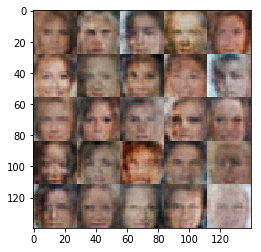

step # 1301
step # 1302
step # 1303
step # 1304
step # 1305
step # 1306
step # 1307
step # 1308
step # 1309
step # 1310
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.9778
step # 1311
step # 1312
step # 1313
step # 1314
step # 1315
step # 1316
step # 1317
step # 1318
step # 1319
step # 1320
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 9.5263
step # 1321
step # 1322
step # 1323
step # 1324
step # 1325
step # 1326
step # 1327
step # 1328
step # 1329
step # 1330
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 2.5705
step # 1331
step # 1332
step # 1333
step # 1334
step # 1335
step # 1336
step # 1337
step # 1338
step # 1339
step # 1340
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 5.2209
step # 1341
step # 1342
step # 1343
step # 1344
step # 1345
step # 1346
step # 1347
step # 1348
step # 1349
step # 1350
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.9907
step # 1351
step # 1352
step # 1353
step # 1354
step # 1355
step # 135

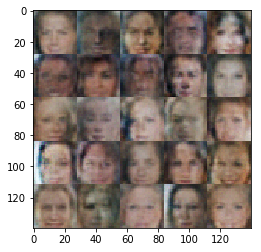

step # 1401
step # 1402
step # 1403
step # 1404
step # 1405
step # 1406
step # 1407
step # 1408
step # 1409
step # 1410
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 5.6280
step # 1411
step # 1412
step # 1413
step # 1414
step # 1415
step # 1416
step # 1417
step # 1418
step # 1419
step # 1420
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 5.3426
step # 1421
step # 1422
step # 1423
step # 1424
step # 1425
step # 1426
step # 1427
step # 1428
step # 1429
step # 1430
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 13.4051
step # 1431
step # 1432
step # 1433
step # 1434
step # 1435
step # 1436
step # 1437
step # 1438
step # 1439
step # 1440
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.2773
step # 1441
step # 1442
step # 1443
step # 1444
step # 1445
step # 1446
step # 1447
step # 1448
step # 1449
step # 1450
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6667
step # 1451
step # 1452
step # 1453
step # 1454
step # 1455
step # 14

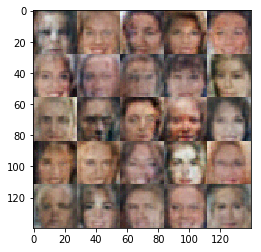

step # 1501
step # 1502
step # 1503
step # 1504
step # 1505
step # 1506
step # 1507
step # 1508
step # 1509
step # 1510
Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 4.8756
step # 1511
step # 1512
step # 1513
step # 1514
step # 1515
step # 1516
step # 1517
step # 1518
step # 1519
step # 1520
Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 4.6146
step # 1521
step # 1522
step # 1523
step # 1524
step # 1525
step # 1526
step # 1527
step # 1528
step # 1529
step # 1530
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 5.7629
step # 1531
step # 1532
step # 1533
step # 1534
step # 1535
step # 1536
step # 1537
step # 1538
step # 1539
step # 1540
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 0.7776
step # 1541
step # 1542
step # 1543
step # 1544
step # 1545
step # 1546
step # 1547
step # 1548
step # 1549
step # 1550
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.3307
step # 1551
step # 1552
step # 1553
step # 1554
step # 1555
step # 155

In [32]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.